In [1]:
import numpy as np 
import cauchy_estimator as ce 
import gaussian_filters as gf
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('TkAgg',force=True)  

In this Jupyter Notebook, the Python API for the Cauchy Estimator will be introduced! This API allows you to interface with a Cauchy Estimator 'Object' as easily as any Kalman filter API would allow you to interact with a Kalman filter 'Object'. We will walk through the main classes of the API and explain how they are used. They are...

1.) The PyCauchyEstimator class, which allows you to create a Cauchy Estimator object for a LTI, LTV, or nonlinear dynamic simulation. This class can be used to run scalar dynamic systems for infinite time horizons, or dynamic systems of two dimensions or larger for several time steps (usually, less than 12 time propagations). In the case of systems $\geq$ 2D, this class is a great way to debug any callback functions you may write (for LTV or nonlinear systems) before using the 'PySlidingWindowManager' (explained next).

2.) The PySlidingWindowManager class, which allows you to run the Cauchy Estimator for infinite time horizons for LTI, LTV, or nonlinear dynamic simulations of two dimensions or greater. Both the PyCauchyEstimator and PySlidingWindowManager classes and their methods are described in this tutorial.

To wrap our heads around the Cauchy Estimator, let's start off by building a Kalman filter for a simple LTI system in a Gaussian noise simulation, run it for 8 time steps, and plot the results. We will do this for a simple two state system, as anything more extravagant is unnecessary for tutorial purposes. The system dynamics and measurement model for an LTI system are defined as
\begin{align}
x_{k} &= \Phi x_{-1} + Bu_{k-1} + \Gamma w_{k-1} \\
z_{k} &= H x_{k} + v_{k}.
\end{align}

Above, $x_k\in\mathbb{R}^n$ is the system's state vector (at time index $k$), $\Phi\in\mathbb{R}^{n\times n}$ is the state transition matrix, $B\in\mathbb{R}^{n\times q}$ is the control gain matrix, $u_k \in \mathbb{R}^{q}$ is a control vector, $\Gamma\in\mathbb{R}^{n\times r}$ is the process noise gain matrix, and $w_k\in\mathbb{R}^{r}$ is the process noise vector with statistics $\mathcal{N}\left(0, W\right)$ where $W\in\mathbb{R}_{++}^{r\times r}$ is a covariance matrix. Above, the measurement vector $z_k\in\mathbb{R}^p$ is modelled with matrix $H\in\mathbb{R}^{p \times n}$ and a measurement noise vector $v_k\in\mathbb{R}^p$ with statistics $\mathcal{N}\left(0, V\right)$ where $V\in\mathbb{R}_{++}^{r\times r}$ is a covariance matrix.

For our example below, $n=2$, $q=0$, $r=1$ $p=1$ (no controls, for now). The dynamics and statistics are defined as: 

In [2]:
Phi = np.array([ [0.9, 0.1], [-0.2, 1.1] ])
Gamma = np.array([.1, 0.3])
B = None # No control matrix, since no controls
us = None # No controls
H = np.array([1.0, 0.5])
W = np.array([[0.01]])
V = np.array([[0.02]])

The Kalman filter has an initial uncertainty in the form of a covariance matrix $P_0\in \mathbb{R}_{++}^{n\times n}$ about its initial state estimate of the system $\hat{x}_0 \in \mathbb{R}^n$.

In [3]:
x0_kf = np.zeros(2)
P0_kf = np.eye(2) * 0.05

Lets create a simulation using these statistics and create some measurements to give the KF using the helper function in the cauchy_estimtor module 'simulate_gaussian_ltiv_system', which can be used to simulate a LTI or LTV system. 

In [4]:
num_propagations = 7
x0_truth = np.random.multivariate_normal(x0_kf, P0_kf) 
xs, zs, ws, vs = ce.simulate_gaussian_ltiv_system(num_propagations, x0_truth, us, Phi, B, Gamma, W, H, V)
# T = num_propagations
# xs = [x_0,x_1,....,x_T] -> T x n array
# zs = [z_0,z_1,....,z_T] -> T x p array (returns a measurement for the initial state time)
# ws = [w_0,w_1,...,w_{T-1}] -> T-1 x r array
# vs = [v_0,v_1,...,v_T] -> T-1 x p array (returns measurement noise for the initial state time)
print("State Hist Shape:", xs.shape, "\nMeasurement Hist Shape:", zs.shape, "\nProcess Noise Hist Shape:",ws.shape, "\nMeasurement Noise Hist Shape:", vs.shape)

State Hist Shape: (8, 2) 
Measurement Hist Shape: (8, 1) 
Process Noise Hist Shape: (7, 1) 
Measurement Noise Hist Shape: (8, 1)


Lets run the Kalman filter and plot the results. The Kalman filter is ubiquitous, and any good online reference will give how (i.e, the five lines of code) to program it. We will use the helper function 'run_kalman_filter' in the gaussian_filters module to run the KF, and then the plot_simulation function in cauchy_estimator module to show the state history plot and the state error plots

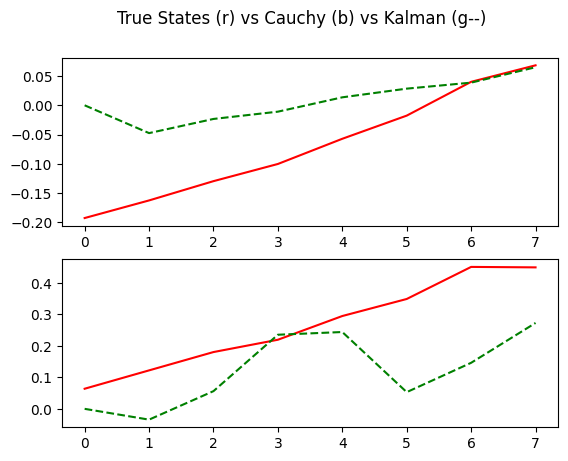

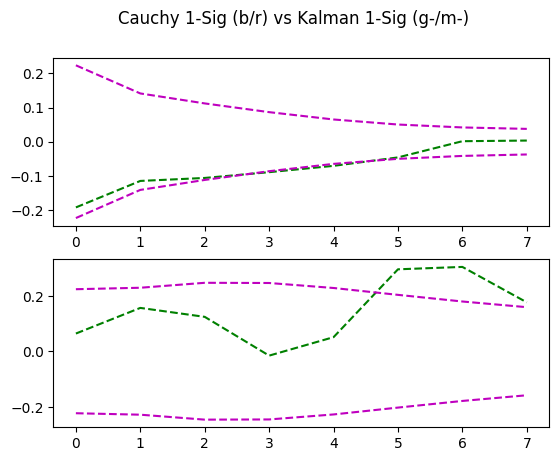

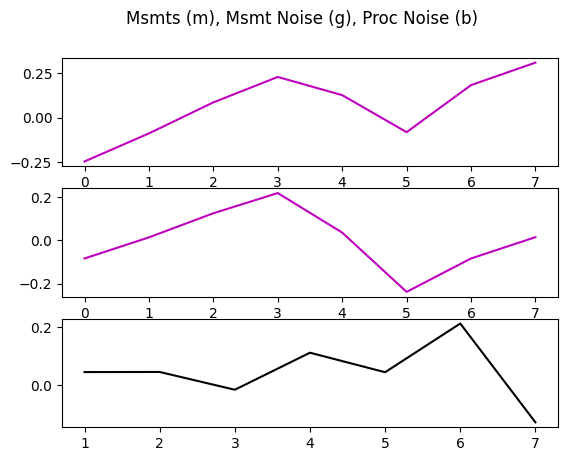

In [5]:
# The function simulate_gaussian_ltiv_system returns a measurement for the initial state x0. We'll discard it here (i.e, use zs[1:]).
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, us, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)
ce.plot_simulation_history(None, (xs,zs,ws,vs), (xs_kf, Ps_kf))
# The first argument to the above function is the Cauchy Estimator's statistics dictionary. Giving 'None' disregards this.

We'll now walk through how to create a Cauchy Estimator for the Gaussian simulation above! Do note that the Kalman filter is the optimal estimation algorithm for LTI/LTV systems driven by additive gaussian noise. The Cauchy Estimator, therefore, wont "magically" work any better than what's shown above. But, we will see that in Gaussian noise, the Cauchy performs almost exactly as well as the Kalman filter performs!

The Cauchy Estimator requires noise statistics as if the process and measurement noises were "Cauchy distributed". One can fit (in a least squares sense) the Cauchy PDF to the Gaussian PDF, and solve for the "scale" parameter of the Cauchy's pdf, which yields the best fit to the Gaussian PDF. You can think of the "scale" parameter of the Cauchy PDF like "standard deviation" for a Gaussian. However, while the previous statement helps you to get an idea of what the "scale" parameter is intuitively, it is grossly wrong. The Cauchy PDF does not have a mean or variance (they are undefined) because of how heavy the tails of its distribution are. So, the Cauchy PDF does not have "standard deviations" away from its mean. A better way to say the latter is that the scale parameter controls the spread of its PDF (its uncertainty).

Regardless, the relationship between the Cauchy's scale parameter and that of the Gaussian's "standard deviation" parameter can be related as $\sigma_c = \frac{1.0}{1.3898} \sigma_g$, where $\sigma_c$ is the scale parameter of the Cauchy PDF and $\sigma_g$ is the standard deviation of the Gaussian PDF. This is the (analytical) result from fitting the Cauchy pdf to the Gaussian PDF. Therefore, we can parameterize the noise statistics of the process, measurement, and initial state uncertainty for the Cauchy Estimator as...

In [6]:
scale_g2c = 1.0 / 1.3898 # Scale the Gaussian's standard deviation by this factor to yield the optimal Cauchy scale parameter
beta = np.array([W[0,0]**0.5]) * scale_g2c # Process noise scale parameter for the Cauchy Estimator
gamma = np.array([V[0,0]**0.5]) * scale_g2c # Measurement noise scale parameter for the Cauchy Estimator
p0 = np.diag(P0_kf)**0.5 * scale_g2c # Initial state uncertainty scale parameters for the Cauchy Estimator
A0 = np.eye(2) # unit directions (row-wise) which describe the directions of initial uncertainty for p0
b0 = x0_kf.copy() # The 'median' vector of the Cauchy Estimator's intial state hypothesis

There are some minor catches with what is presented above: (the below is a slight, but important, tangent)

1.) The process noise scale parameters ($\beta \in \mathbb{R}_{++}^r$) are assumed to be independent of one another. For example, if the discrete state dynamics happen to be derived from continous time dynamics 
\begin{equation}
    \dot{x} = A x + \Gamma_c w
\end{equation}
where $\Gamma_c \in \mathbb{R}^{n \times r}$ and $w \in \mathbb{R}^r$ has (diagonal) power spectral density $W$, a common way to discrete the process noise is:
\begin{align}
    w_k \sim& \mathcal{N}\left(0,W_k\right), \quad W_k = \int_{t_k}^{t_{k+1}} e^{A \tau} \Gamma_c W \Gamma_c^T \left(e^{A \tau}\right)^T d\tau \\
    x_{k+1} &= e^{A\Delta} x_k + w_k, \quad \Delta = t_{k+1} - t_k
\end{align}
This is not acceptable for the Cauchy Estimator, however, as it yields cross terms in $W_k$. Instead, a discretization process, such as 
\begin{align}
    \Gamma_k &= \int_{t_k}^{t_{k+1}} e^{A\tau}\Gamma_c d\tau, \\
    x_{k+1} &= e^{A\Delta}x_k + \Gamma_k w_k, \\
     w_k \sim& \mathcal{N}\left(0,W_k\right), \quad W_k = \frac{W}{\Delta}, \quad \Delta = t_{k+1} - t_k,
\end{align}
is the way this estimator requires discretization. Now, $w_k$ has $r$ independent discrete time process noises, which are then operated on by $\Gamma_k$. From much experimentation, we have found this effects estimation ability extremely little. The only catch with the discretization process laid out above is that the continous time power spectral density should (must) be modelled with no cross terms. Furthermore, if the system dynamics are inherently discrete to begin with, one must directly model the noises as uncorrelated to one another, so that the $\beta$-vector has independent scale parameters.

2.) The measurement noise scale parameters $\gamma \in \mathbb{R}_{++}^{p}$ should also be independent of one another. Therefore, no cross term modelling is allowed in the measurement statistics either.

3.) The initial state's uncertainty scale parameters $p_0\in\mathbb{R}^n$ will assume independence between states to begin IFF $A_0 \in \mathbb{R}^{n\times n}$ is set to the identity matrix. Essentially, $A_0$ informs the estimator how the initial state's uncertainty is coupled. Typically, this is set to identity if the states uncertainty is modelled uncoupled to begin. $A_0$ can be set to some orthogonal matrix as well to inform the estimator how the states are initially coupled. However, there are some cases where it is set to $\Phi^T$ to begin. This will be ellaborated on more in the next tutorial. However, here the KF assumes the system's state is uncorrelated initially, and therefore we set $A_0 = I$ and the scale parameters $p_0$ to the respective standard deviation of each covariance matrix diagonal element, divided by 1.3898.

4.) The median parameter vector $b_0$ can simply be set to the initial state hypothesis. Therefore its just set to the KF's initial state hypothesis.


That was a lot, but you can see setting up the Cauchy Estimator's statistics is no more than 5 lines of code above. Now we can create the Cauchy Estimator Object for this LTI problem as:

Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!


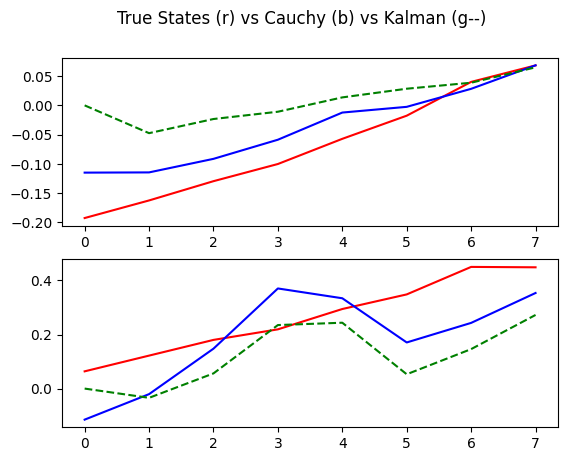

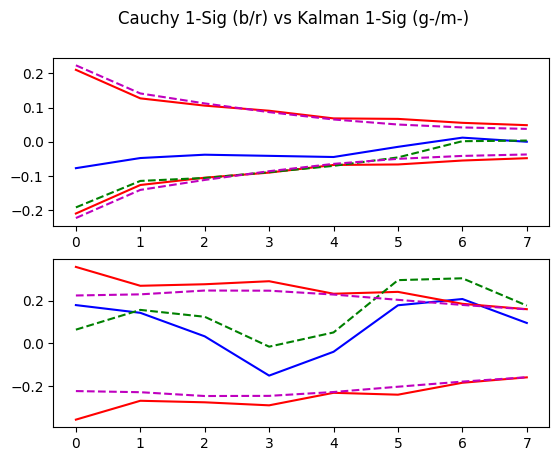

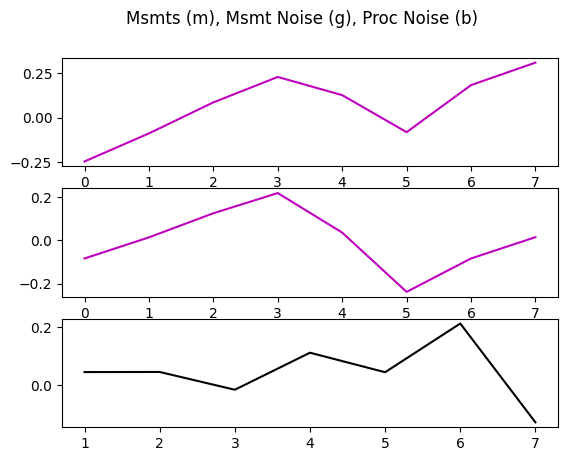

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


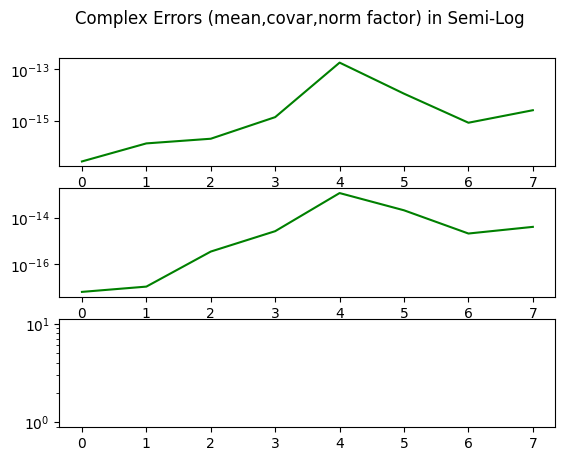

Cauchy estimator backend C data structure has been shutdown!


In [7]:
# Initialize the Cauchy Estimator Python Object
steps = num_propagations+1
print_debug = False # Change this to true to see intermediate print out after each measurement has been processed
cauchyEst = ce.PyCauchyEstimator("lti", steps, print_debug)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)

# Give it the measurements 
u = None # no controls
for zk in zs:
    # returns the conditional mean xk and covariance matrix Pk at each estimation step
    # this object also has an internal dictionary moment_info which stores this (and more) as well
    xk, Pk = cauchyEst.step(zk, u) 
ce.plot_simulation_history(cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf))
cauchyEst.shutdown()

Lets go over what just happened. To use the Cauchy Estimator, first create the estimation object (above with ce.PyCauchyEstimator(mode, steps, print_debug)) by telling it the mode (i.e, 'lti', 'ltv', or 'nonlin'), the number of total steps (time propagation steps plus 1) you'll run it for, and if you wish to see intermediate print output. We'll see in the next tutorial how to initialize this estimator for nonlinear and LTV systems.

Next, we call its 'initialize_lti()' method, which simply passes in the system dynamics, process, measurement, and initial state uncertainty statistics. The measurements are looped over, using the Cauchy Estimator's method '.step($z_k, u_{k-1}$)' to process the measurement and control at each estimation step $k$. Note that if the estimator does take controls as input, we would call '.step($z_0$, None)' at the initial time step, and then '.step($z_1, u_0$)' at the next. We need to supply a measurement initially, as the unconditional first and second moment of a state assumed Cauchy distributed is undefined. Another way of saying this is that $\mathbb{E}[x_0] = \infty$, $\mathbb{E}[x_0x_0^T] = \infty$ with the Cauchy modelling assumption, however, the conditonal first and second moment $\mathbb{E}[x_0|z_0]$ and $\mathbb{E}[x_0x_0^T|z_0]$ yields finite values.

The function 'ce.plot_simulation_history()' then plots out the results of the simulation. The first plot depicts the true state history, as well as the Kalman filter and Cauchy's state estimates. The second plot shows the error of the state hypotheses bounded by each estimator's 1-sigma bound (i.e, $\pm$ the square root of the diagonal elements of the conditional covariance matrix). A well tuned estimator should have the state estimation error bounded by the 1-sigma confidence interval at least 68% of the time. Last, some numerical stability stats are plotted for the Cauchy estimator. These numerical stability stats are shown as the estimator sums and multiplies complex numbers together to form the conditional mean and covariance estimates. The result of the complex-typed multiplications and summations yields real values, with very small complex quantities due to computer roundoff error. Typically, this information can be discarded, as the errors are usually quite small and unimportant.

The results speak for itself: in Gaussian noise, the Cauchy Estimator's results look just like that of the Kalman filters!

One important aspect (which we will see a lot more of) is that the Cauchy's conditional covariance is an explicit function of the measurement history. This is much different than the Kalman filter, whose posterior covariance is truly a-priori known. The Cauchy Estimator's conditional covariance will therefore dynamically adapt to the measurement realization given.

Lets go ahead and run the simulation much longer. We can use the PySlidingWindowManager to do this as shown below:

Set Sliding Window Manager Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note:

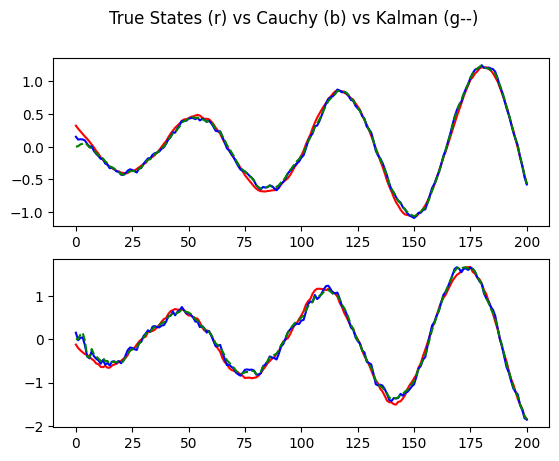

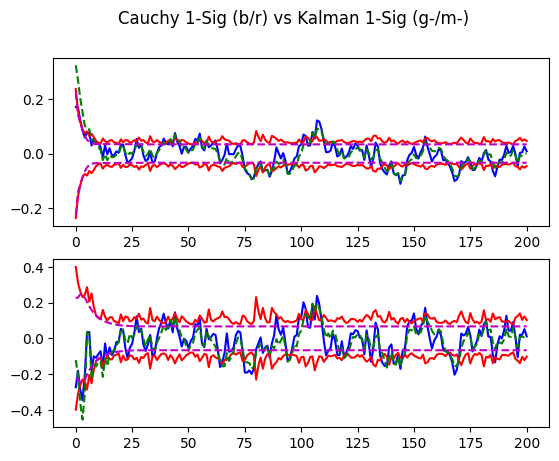

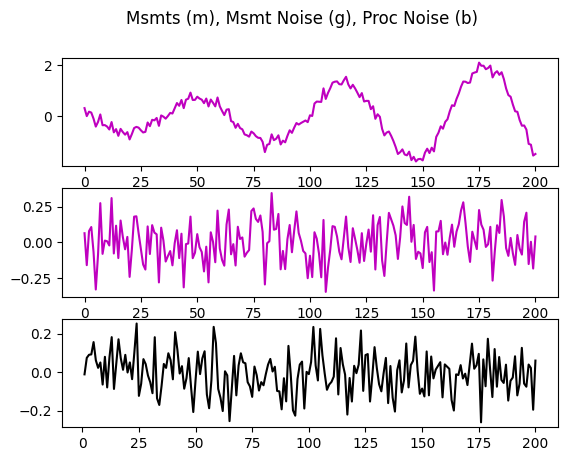

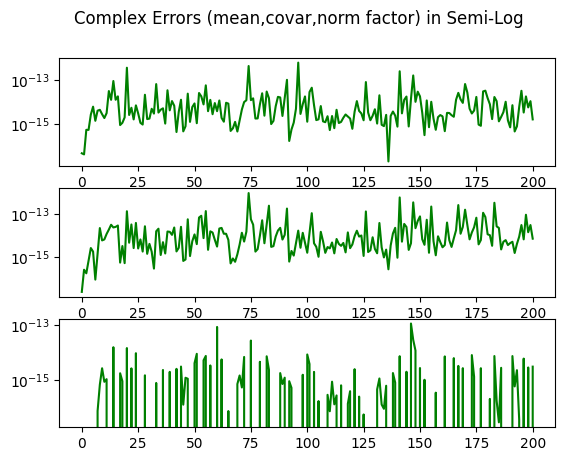

In [8]:
# Create a longer simulation
num_propagations = 200
x0_truth = np.random.multivariate_normal(x0_kf, P0_kf) 
xs, zs, ws, vs = ce.simulate_gaussian_ltiv_system(num_propagations, x0_truth, us, Phi, B, Gamma, W, H, V)

# Run the Kalman filter
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, None, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)

# Running the Cauchy estimator for long time horizons
num_windows = 8
swm_print_debug = False # Turn this on to see basic window information
win_print_debug = False # Turn this on to see indivdual window (estimator) information

cauchyEst = ce.PySlidingWindowManager("lti", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)
u = None
for zk in zs:
    # Below, xk and Pk are the conditional mean and covariance given by a window (estimator)...
    # ...which has processed the most measurements at the current time step
    # Below, wavg_xk and wavg_Pk are the weighted averages of the conditional mean and covariance across all windows...
    # ...which typically varies litlle from xk and Pk, but in some cases, can yield much smoother trajectories

    # The sliding window manager is explained in more detail below the generated figures
    xk, Pk, wavg_xk, wavg_Pk = cauchyEst.step(zk, u)
cauchyEst.shutdown()
# Plot results
ce.plot_simulation_history(cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf))
# One could also plot the (weighted) averaged conditional mean and covariance history between all windows
#ce.plot_simulation_history(swm.avg_moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf))

Three things are immediately clear from the above Gaussian simulation:

1.) In Gaussian noise, the Cauchy Estimator is almost identical to the Kalman filter.

2.) Its conditional covariance forms a tight upper bound to that of the KF's covariance (checkout the respective 1-sigma bounds above).

3.) Its conditional covariance dynamically adjusts as a function of the measurement history.

We use the 'Sliding Window Manager' class as the number of terms embedded in the Cauchy Estimator grows with each measurement processed. Here is probably a good time to dive a little deeper into the backend of the estimator, and give you some justification as to why we need a structure to truncate term growth:

The Cauchy Estimator uses the Characteristic Function (CF) of the conditonal PDF to (analytically and recursively) propagate and construct the conditional mean and covariance after processing measurements at each time step. The CF is written as
\begin{align}
    \phi_{X_k|Y_k}(\nu) &= \int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty} f_{X_k|Y_k}(x_k|y_k)e^{j\nu^Tx_k} dx_1 \cdots dx_n = \sum_{i=1}^{N_t^{k|k}}g_i^{k|k}(\nu)\text{exp}\left(y^{k|k}_{ei}(\nu)\right)\\
    y_k &= \{z_0,z_1,...,z_k\}\\
\end{align}
where $N_t^{k|k}$ is the number of terms in the estimator at time step $k$. Beginning at $k=0$, there is 1 'term', composed of three 'term elements' (our initialization parameters!) $A_0,p_0,b_0$. The functions $g_i^{k|k}(\nu)$ and $y^{k|k}_{ei}(\nu)$ are functions of these parameters and the measurement sequence $y_k$. 

After processing the first measurement at $k=0$, we will now have $n+1$ terms total, each with (newly transformed) parameters $\{A_i,p_i,b_i\}$ where $i \in [1,..,n+1]$ is the term index and $n$ the state dimension. If we were to process another measurement directly after this one (i.e, no time propagation in between), each of these terms then produces $n$ new terms, yielding a total of $n^2+2n+1$ terms, each having newly updated parameters $A_i,p_i,b_i$ that define the $g_i^{k|k}(\nu)$ and $y^{k|k}_{ei}(\nu)$ functions. The takeaway is that processing measurements generates more terms in the above sum. 

At time propagation from $k=0$ to $k=1$, we do not generate any new terms, but instead, each term's $A_i, p_i$ elements grow larger ($A_i$ adds rows to its matrix, $p_i$ adds elements to its vector). If $\Gamma_k$ has $r$ columns, each $A_i$ adds $r$ rows (it appends $\Gamma_k$) and each $p_i$ adds $r$ elements (it appends $\beta$). The vector $b_i$ always remains $n$-dimensional.

When processing the next measurement at $k=1$ (after time propagation), each term will now generate $n+r$ new terms. Essentially, each term generates as many new terms as it has rows in its $A_i$ (or equivalently, coefficients in the $p_i$ vector). In general then, the recursion rule for term growth is:
\begin{align}
    m_i^{0|0} &= n\\
    m_i^{k+1|k} &= m_i^{k|k}+r\\
    N_t^{0|-1} &= 1, \quad N_t^{0|0} = n+1\\
    N_t^{k+1|k} &= N_t^{k|k}\\
    N_t^{k+1|k+1} &= \sum_{i=1}^{N_t^{k|k+1}} m_i^{k+1|k} + 1 
\end{align}
where $m_i^{k|k}$ is the number of rows in the $A_i$ matrix, or equivalently the number of coefficients in $p_i$, at step $k$. The $N_t^{0|-1}$ represents that before any measurement update (at initialization) we have a single term, and $N_t^{0|0}$ represents that after the first measurement update we'd have $n+1$ terms.

The above is a bit of a simplification. After each time propagation, certain terms reduce in the number of coeffients $m_i^{k|k-1}$ they hold. After a measurement update, many more terms reduce in the number of coefficients $m_i^{k|k}$ they hold. After each measurement update, many terms reduce with one another ($N_t^{k|k}$ reduces typically by a factor of 2-10). Moreover, some terms become negligable, and are discarded. Despite this, the number of terms will increase, and for this reason, we need a strategy to keep the computation fixed, and our computer memory from eventually running out.

The 'Sliding Window' mechanism fixes the computational growth issue by running a bank of estimators (windows) each lagged one time step from its neighboring window. It is illustrated below. Note this illustration was used to explain a GPU version of the estimator, changing the word GPU to CPU makes it applicable here.


![title](imgs/window_bank.png)

As seen above, once a window processes W steps of measurements, it reports its conditional mean and covariance estimates, and resets. At the next step, its neighboring window is now full. It then reports its conditional mean and covariance estimates, but also reinitialize the (previously full) window to have the exact same mean and covariance as it does, using the current measurement. This mechanism exploits a useful result to construct (for the reinitialized window) a desired (the full window's) mean and covariance using a single (the current) measurement. Now, the reinitialized window is "reset" around the best estimate of the system, and gives the reinitialized window (estimator) "memory". This process repeats indefinetely. Therefore, this structure keeps each state estimate a function of only the measurements of the last W steps, and as a result, the computation, memory, and execution rate of the estimator remains fixed. 

Smaller window banks run quicker than larger window banks, since the number of terms in each window (estimator) will be less. Typically, a window bank of four (each estimate is a function of the last 4 time steps) is sufficient, and a window bank of 8 is plenty.

That was a lot of detail again, but hopefully, better intuition into how the estimator works has been gained.

Using the Cauchy Estimator doesnt have much utility over the Kalman filter when the noises are Gaussian, as the KF is the optimal estimator. However, we will see next the tremendous advantage the Cauchy Estimator has when the noises become more impulsive than the Gaussian distribution suggests. For example, lets now assume the simulation noises are Cauchy distributed (very heavy-tailed).

Set Sliding Window Manager Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 8 time-steps, 1 measurements per step == 8 total times!
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note:

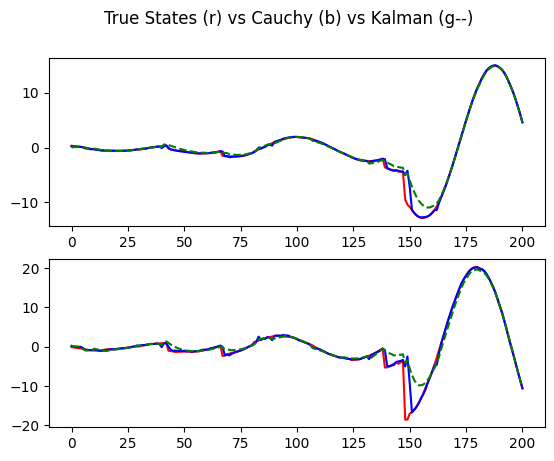

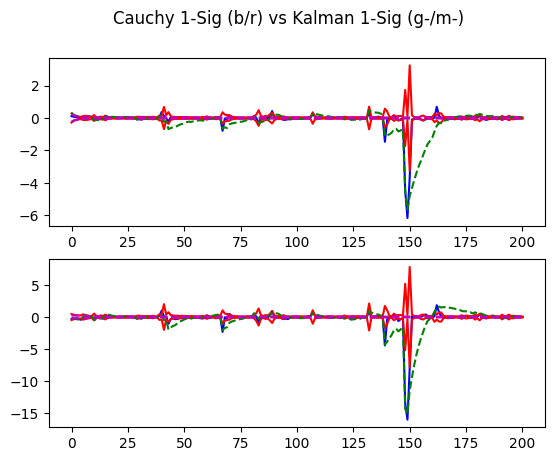

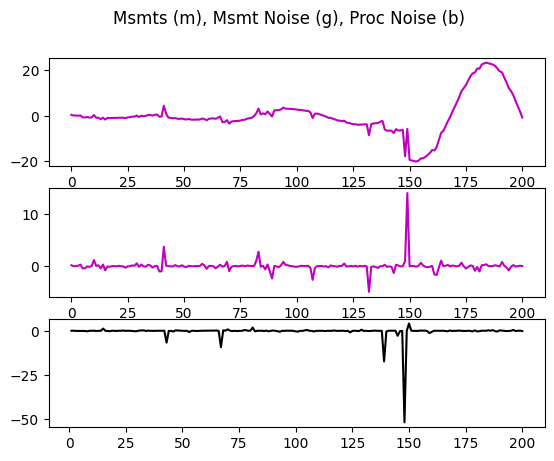

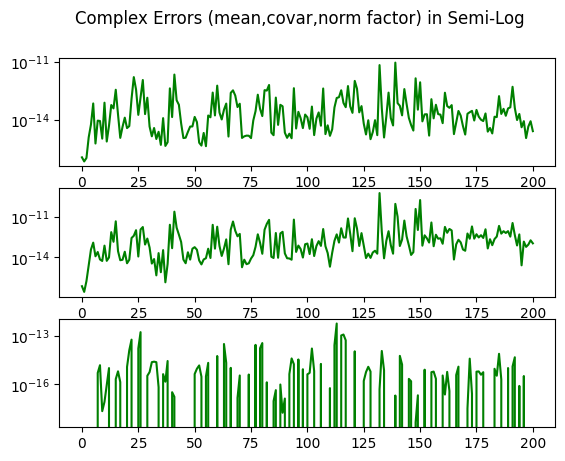

In [9]:
# Construct a Cauchy noise simulation
xs, zs, ws, vs = ce.simulate_cauchy_ltiv_system(num_propagations, x0_truth, us, Phi, B, Gamma, beta, H, gamma)
# Run the Kalman filter
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, None, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)
# Run the Cauchy Estimator
cauchyEst = ce.PySlidingWindowManager("lti", num_windows, swm_print_debug, win_print_debug)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)
u = None
for zk in zs:
    cauchyEst.step(zk, u)
cauchyEst.shutdown()
ce.plot_simulation_history(cauchyEst.moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf))
#ce.plot_simulation_history(swm.avg_moment_info, (xs,zs,ws,vs), (xs_kf, Ps_kf))

As seen above, the process and measurement noise outliers cause the Kalman filter to accumulate large errors for long time periods. Running the above codeblock several times may be helpful to see the Cauchy's behaviour for several different relaizations. One thing is very clear: the Cauchy's covariance tells you exactly when it believes outlier events occur, by dynamically increasing its covariance temporarily. We see, in contrast, the Kalman filter error simply diverges far outside its 1-sigma bounds. From above, it is blatantly obvious the Cauchy Estimator is superior when the noises become heavy tailed.

The question now becomes, why is the Cauchy Estimator so much better than the Kalman filter when noises are impulsive? Outlier events can arise from two sources: the process and the measurement noise. So, there must be some reason as to why the estimation performance of the Cauchy is superior in heavy-tailed noise. The secret, as we will see next, lies in the very rich conditional probability density function it is able to generate. Let's explore the following two hypotheses, using some code:

1.) The Cauchy Estimator can track large jumps in the process.

2.) The Cauchy Estimator will ignore, or quickly disregard, large measurement noises

Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 7 time-steps, 1 measurements per step == 7 total times!
2D Grid Eval Step 3:
  Caching took: 0 ms (25 CF terms)
  Computing 7171 gridpoints took: 11 ms (used 8 threads)
  Total Time: 11 ms
2D Grid Eval Step 4:
  Caching took: 1 ms (67 CF terms)
  Computing 7171 gridpoints took: 31 ms (used 8 threads)
  Total Time: 32 ms
2D Grid Eval Step 5:
  Caching took: 0 ms (177 CF terms)
  Computing 7171 gridpoints took: 44 ms (used 8 threads)
  Total Time: 44 ms
2D Grid Eval Step 6:
  Caching took: 1 ms (465 CF terms)
  Computing 7171 gridpoints took: 112 ms (used 8 threads)
  Total Time: 113 ms


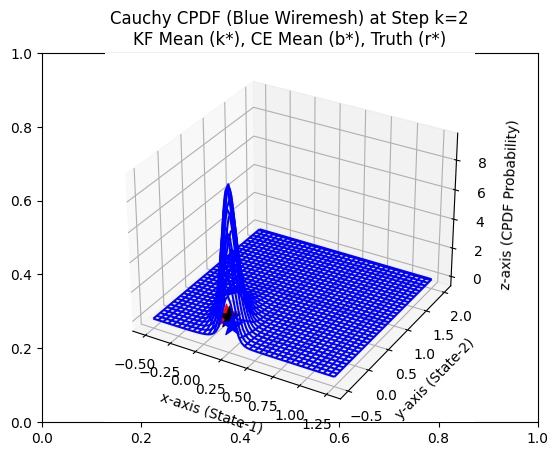

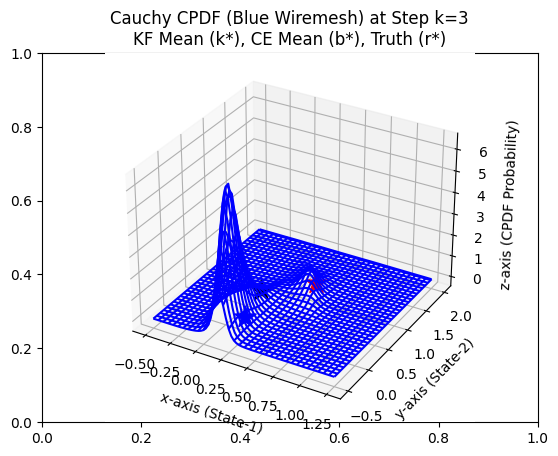

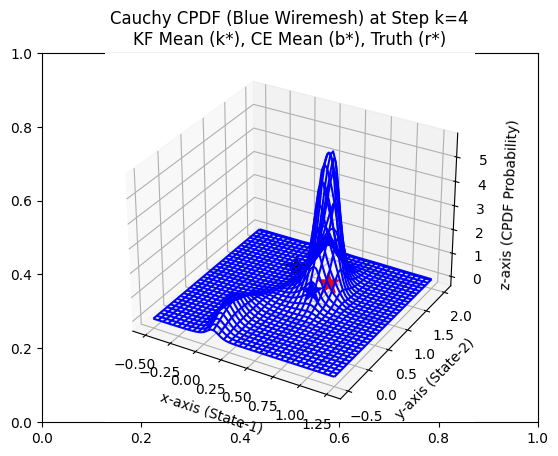

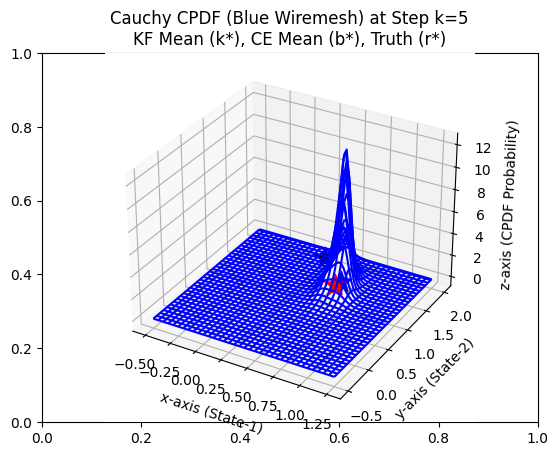

Cauchy estimator backend C data structure has been shutdown!


In [10]:
# 1.) Lets hand craft a small simulation where a large process noise enters the system
steps = 7
ws = np.array([0.05,-0.03, 4.0, 0.1, -0.07, 0.08]) # large process noise jump between k=2 and k=3
vs = np.array([0.08, 0.1, -0.03, -0.07, 0.09, 0.13, 0.02])
xk = np.array([0.0,0.0])
xs = [xk]
zs = [H @ x0_truth + vs[0]]
for i in range(steps-1):
    xk = Phi @ xk + Gamma * ws[i]
    xs.append(xk)
    zs.append(H @ xk + vs[i+1])
xs = np.array(xs)
zs = np.array(zs)

# Run KF 
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, None, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)

# Run CE and Plot its CPDF along the way
cauchyEst = ce.PyCauchyEstimator("lti", steps, debug_print=False)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)
for i in range(zs.shape[0]):
    zk = zs[i]
    xk, Pk = cauchyEst.step(zk)
    if i > 1 and i < 6:
        grid_lowx = -0.50 # CPDF Grid Low X
        grid_highx = 1.25 # CPDF Grid High X
        grid_resx = 0.025 # CPDF Resolution in X
        grid_lowy = -0.50 # CPDF Grid Low Y
        grid_highy = 2.0 # CPDF Grid High Y
        grid_resy = 0.025 # CPDF Resolution in Y
        # Get CPDF Grid over X and Y (f_XY)
        Xs, Ys, f_XY = cauchyEst.get_2D_pointwise_cpdf(grid_lowx, grid_highx, grid_resx, grid_lowy, grid_highy, grid_resy)
        # Plot 
        fig = plt.figure()
        plt.title("Cauchy CPDF (Blue Wiremesh) at Step k=" + str(i) + "\nKF Mean (k*), CE Mean (b*), Truth (r*)")
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(Xs, Ys, f_XY, zorder=1, color='b')
        ax.set_xlabel("x-axis (State-1)")
        ax.set_ylabel("y-axis (State-2)")
        ax.set_zlabel("z-axis (CPDF Probability)")
        # Plot conditional mean of Cauchy Estimator 
        ax.scatter(xk[0], xk[1], 0, color='b', marker = '*', s=260, zorder=2)
        # Plot conditional mean of Kalman filter
        ax.scatter(xs_kf[i][0], xs_kf[i][1], 0, color='k', marker = '*', s=260, zorder=3)
        # Plot True State Location
        ax.scatter(xs[i][0], xs[i][1], 0, color='r', marker = '*', s=260, zorder=4)
plt.show()
cauchyEst.shutdown()

The result above is somewhat remarkable. The Cauchy Estimator has the ability to create multi-peaked PDFs, analytically! This is only possible (heuristically) using particle or Gaussian sum filters. When the state jumps at step $k=3$, we see the Cauchy Estimator bifurcates its CPDF, hedging between two possible outcomes: either the state has jumped, or measurement noise has created a measurement outlier. At $k=4$, the estimator switches its hypothesis that its much more likely the state has jumped. At $k=5$, it returns to a unimodal distribution. Note that its (minimum variance) conditional mean estimate does not always lie at a peak of its distribution, whereas the Kalman filters always will. 

To account for multiple state hypotheses, the Cauchy Estimator can not only bifurcate its CPDF, but also trifurcate, quadfurcate, etc etc, its CPDF, all analytically! The following example shows a scenario where the Cauchy trifurcates its CPDF: when there are two process noise channels, a single observation channel, and a process noise enters the system through one of the channels.

Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
2D Grid Eval Step 2:
  Caching took: 0 ms (12 CF terms)
  Computing 4641 gridpoints took: 2 ms (used 8 threads)
  Total Time: 2 ms
2D Grid Eval Step 3:
  Caching took: 0 ms (46 CF terms)
  Computing 4641 gridpoints took: 13 ms (used 8 threads)
  Total Time: 13 ms
2D Grid Eval Step 4:
  Caching took: 1 ms (173 CF terms)
  Computing 4641 gridpoints took: 66 ms (used 8 threads)
  Total Time: 67 ms
2D Grid Eval Step 5:
  Caching took: 1 ms (647 CF terms)
  Computing 4641 gridpoints took: 127 ms (used 8 threads)
  Total Time: 128 ms


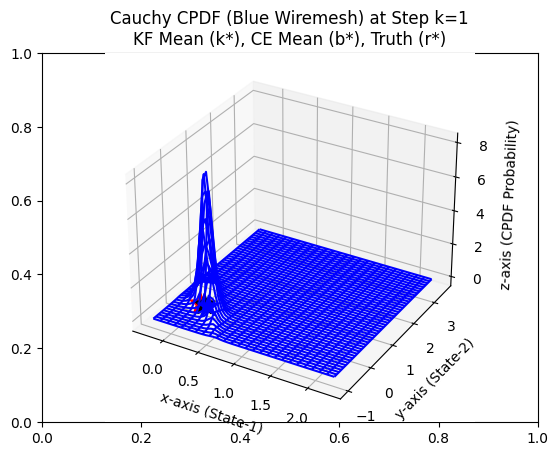

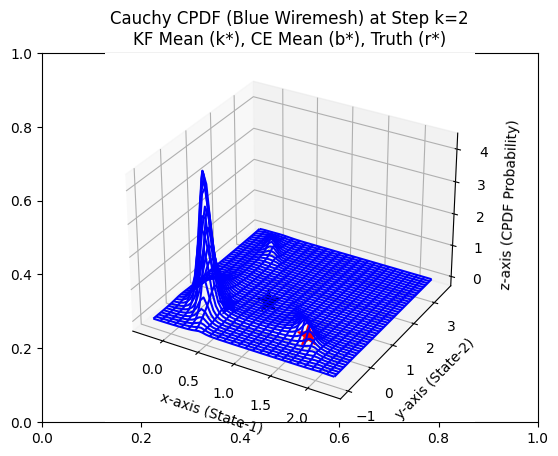

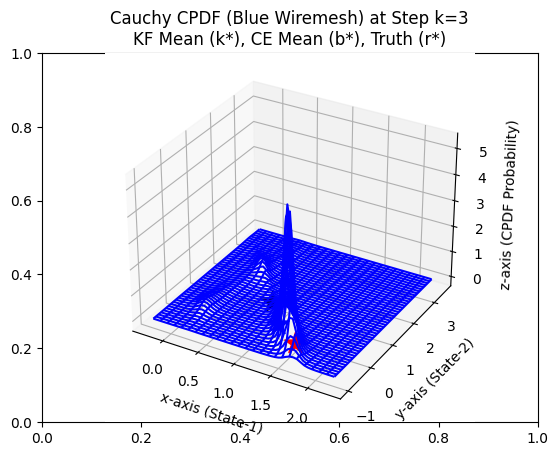

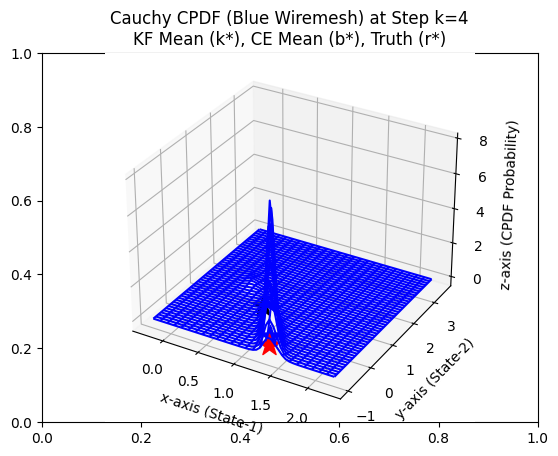

Cauchy estimator backend C data structure has been shutdown!


In [11]:
# 1b.) Lets hand craft a small simulation where a process noise enter the system in one of two channels
steps = 6
Gamma = np.eye(2) # two independent process noise channels
beta = np.array([0.02, 0.02])
scale_c2g = 1/scale_g2c
W = np.diag(beta) * scale_c2g # scale Gaussian to fit Cauchy distribution (in least squares sense)

ws = np.array([[0.05, 1.50,  0.10, -0.07, 0.10],
              [0.03, 0.08, -0.12,  0.02, -0.09]]).T # large process noise jump between k=2 and k=3
vs = np.array([0.08, 0.1, -0.03, -0.07, 0.09, 0.1])
xk = np.array([0.0,0.0])
xs = [xk]
zs = [H @ x0_truth + vs[0]]
for i in range(steps-1):
    xk = Phi @ xk + Gamma @ ws[i]
    xs.append(xk)
    zs.append(H @ xk + vs[i+1])
xs = np.array(xs)
zs = np.array(zs)

# Run KF 
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, None, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)

# Run CE and Plot its CPDF along the way
cauchyEst = ce.PyCauchyEstimator("lti", steps, debug_print=False)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)
for i in range(zs.shape[0]):
    zk = zs[i]
    xk, Pk = cauchyEst.step(zk)
    if (i > 0) and (i < 5):
        grid_lowx = -0.250 # CPDF Grid Low X
        grid_highx = 2.25 # CPDF Grid High X
        grid_resx = 0.05 # CPDF Resolution in X
        grid_lowy = -1.0 # CPDF Grid Low Y
        grid_highy = 3.5 # CPDF Grid High Y
        grid_resy = 0.05 # CPDF Resolution in Y
        # Get CPDF Grid over X and Y (f_XY)
        Xs, Ys, f_XY = cauchyEst.get_2D_pointwise_cpdf(grid_lowx, grid_highx, grid_resx, grid_lowy, grid_highy, grid_resy)
        # Plot 
        fig = plt.figure()
        plt.title("Cauchy CPDF (Blue Wiremesh) at Step k=" + str(i) + "\nKF Mean (k*), CE Mean (b*), Truth (r*)")
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(Xs, Ys, f_XY, zorder=1, color='b')
        ax.set_xlabel("x-axis (State-1)")
        ax.set_ylabel("y-axis (State-2)")
        ax.set_zlabel("z-axis (CPDF Probability)")
        # Plot conditional mean of Cauchy Estimator 
        ax.scatter(xk[0], xk[1], 0, color='b', marker = '*', s=260, zorder=2)
        # Plot conditional mean of Kalman filter
        ax.scatter(xs_kf[i][0], xs_kf[i][1], 0, color='k', marker = '*', s=260, zorder=3)
        # Plot True State Location
        ax.scatter(xs[i][0], xs[i][1], 0, color='r', marker = '*', s=260, zorder=4)
plt.show()
cauchyEst.shutdown()

We see the estimator now makes three hypotheses at $k=2$ when the process jumps. The nominal (largest) peak is hypothesizing that the measurement outlier is due to measurement noise. The second and third peaks hypothesize which channel the process noise has come into. At $k=3$ the estimator shifts the majority of the probability mass to the correct hypothesis. At $k=4$ it resolves the outlier event and returns to a unimodal distribution. All completely analytic, no heuristics. The Kalman filter, meanwhile, is out in no-mans land. Now, we intuitevly understand why the Cauchy tracks jumps in the process so well: its rich, underlying, (multi-peaked capable) conditional cpdf that it constructs. 

When measurement noise enters the system, the results follow very similarly. Lets see an example below. As an aside, visualizing the CPDF is only possible in one or two dimensions, as we can only plot up to 3D. However, we can always look at the marginal conditional PDF of a single state, or the marginalized joint conditional PDF between two states. This functionality is highlighted below for a single state.

Set Cauchy Estimator Mode to: lti
LTI initialization successful! You can use the step(msmts, controls) method to run the estimtor now!
Note: You can call the step function 6 time-steps, 1 measurements per step == 6 total times!
1D Grid Eval Step 2:
  Caching took: 0 ms (12 CF terms)
  Computing 8001 gridpoints took: 4 ms (used 8 threads)
  Total Time: 4 ms
1D Grid Eval Step 2:
  Caching took: 0 ms (12 CF terms)
  Computing 8001 gridpoints took: 4 ms (used 8 threads)
  Total Time: 4 ms
1D Grid Eval Step 3:
  Caching took: 0 ms (46 CF terms)
  Computing 8001 gridpoints took: 6 ms (used 8 threads)
  Total Time: 6 ms
1D Grid Eval Step 3:
  Caching took: 0 ms (46 CF terms)
  Computing 8001 gridpoints took: 1 ms (used 8 threads)
  Total Time: 1 ms
1D Grid Eval Step 4:
  Caching took: 0 ms (173 CF terms)
  Computing 8001 gridpoints took: 2 ms (used 8 threads)
  Total Time: 2 ms
1D Grid Eval Step 4:
  Caching took: 0 ms (173 CF terms)
  Computing 8001 gridpoints took: 1 ms (used 8 threads)
  T

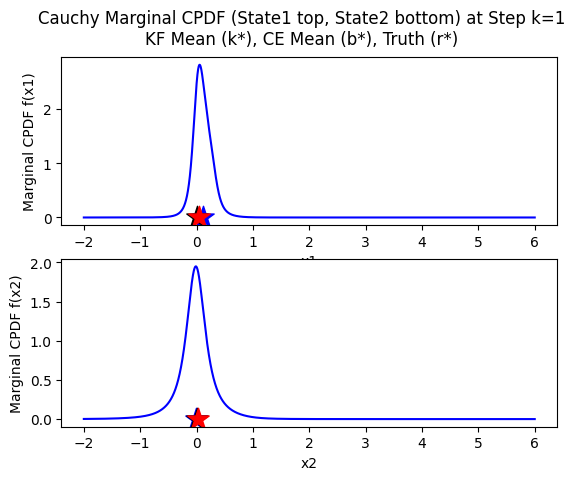

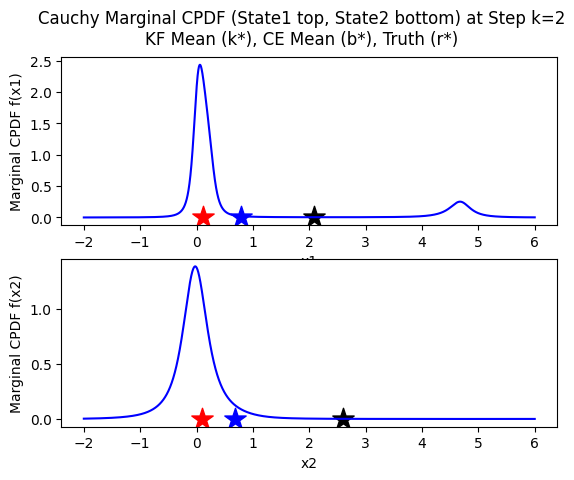

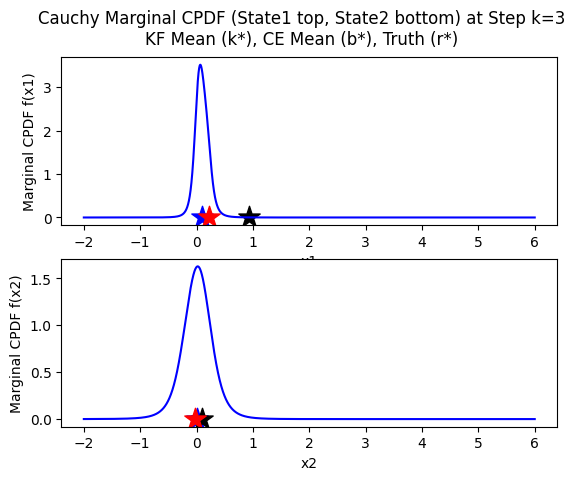

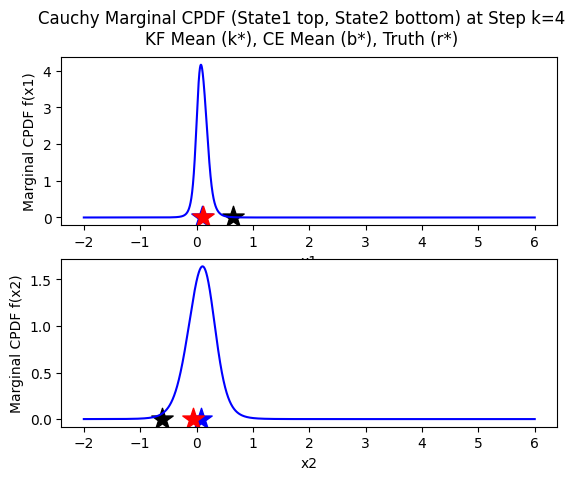

Cauchy estimator backend C data structure has been shutdown!


In [12]:
# 2.) Lets hand craft a small simulation where a large measurement noise enters the system
steps = 6
ws = np.array([[0.05, 0.07,  0.10, -0.07, 0.10],
              [0.03, 0.08, -0.12,  0.02, -0.09]]).T 
vs = np.array([0.08, -0.05, 4.5, -0.07, 0.09, 0.1]) # large measurement noise at k=2
xk = np.array([0.0,0.0])
xs = [xk]
zs = [H @ x0_truth + vs[0]]
for i in range(steps-1):
    xk = Phi @ xk + Gamma @ ws[i]
    xs.append(xk)
    zs.append(H @ xk + vs[i+1])
xs = np.array(xs)
zs = np.array(zs)

# Run KF 
xs_kf, Ps_kf = gf.run_kalman_filter(x0_kf, None, zs[1:], P0_kf, Phi, B, Gamma, H, W, V)

# Run CE and Plot its CPDF along the way
cauchyEst = ce.PyCauchyEstimator("lti", steps, debug_print=False)
cauchyEst.initialize_lti(A0, p0, b0, Phi, B, Gamma, beta, H, gamma)
for i in range(zs.shape[0]):
    zk = zs[i]
    xk, Pk = cauchyEst.step(zk)
    if (i > 0) and (i < 5):
        grid_lowx = -2 # CPDF Grid Low X
        grid_highx = 6 # CPDF Grid High X
        grid_resx = 0.001 # CPDF Resolution in X
        # Get Marginal CPDF Grid over X
        state1_idx = 0
        X1, f_X1 = cauchyEst.get_marginal_1D_pointwise_cpdf(state1_idx, grid_lowx, grid_highx, grid_resx)
        state2_idx = 1
        X2, f_X2 = cauchyEst.get_marginal_1D_pointwise_cpdf(state2_idx, grid_lowx, grid_highx, grid_resx)
        # Plot 
        fig = plt.figure()
        plt.suptitle("Cauchy Marginal CPDF (State1 top, State2 bottom) at Step k=" + str(i) + "\nKF Mean (k*), CE Mean (b*), Truth (r*)")
        # Plot Marginal CPDF of State 1, conditional mean of Cauchy Estimator, Kalman filter, and True State Location
        plt.subplot(211)
        plt.plot(X1, f_X1, 'b')
        plt.scatter(xk[0], 0, color='b', marker = '*', s=260)
        plt.scatter(xs_kf[i][0], 0, color='k', marker = '*', s=260)
        plt.scatter(xs[i][0], 0, color='r', marker = '*', s=260)
        plt.xlabel("x1")
        plt.ylabel("Marginal CPDF f(x1)")
        # Plot Marginal CPDF of State 2, conditional mean of Cauchy Estimator, Kalman filter, and True State Location
        plt.subplot(212)
        plt.plot(X2, f_X2, 'b')
        plt.scatter(xk[1], 0, color='b', marker = '*', s=260)
        plt.scatter(xs_kf[i][1], 0, color='k', marker = '*', s=260)
        plt.scatter(xs[i][1], 0, color='r', marker = '*', s=260)
        plt.xlabel("x2")
        plt.ylabel("Marginal CPDF f(x2)")
plt.show()
cauchyEst.shutdown()

Some concluding remarks are given:

*To plot the joint marginal CPDF between two states (in simulations of three states or more), you can always use the function "cauchyEst.get_marginal_2D_pointwise_cpdf(marg_idx1, marg_idx2, gridx_low, gridx_high, gridx_resolution, gridy_low, gridy_high, gridy_resolution)" where marg_idx1, marg_idx2 $\in [0,...,n-1]$ are the state indices using python idexing (starting from 0).

*To plot the CPDF of an individual window (estimator) when using the PySlidingWindowManager class, access the respective window and call the respective CPDF function: ie: cauchyEst.cauchyEsts[0].get_marginal_1D_pointwise_cpdf(...) would access the first window and plot the marginal cpdf for a state index of your choice.

*Many more examples of the functionality seen here are located in the scripts/swig/cauchy/test_pycauchy.py python script

In the next tutorial, we will see how to setup the estimator for nonlinear systems!